# Генерация датасета для обучения модели по фото и маскам

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/plants/archive.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [49]:
import os
from PIL import Image
import numpy as np
import json
import random
import cv2
from google.colab.patches import cv2_imshow
from collections import defaultdict

!pip install rectpack
from rectpack import newPacker

In [5]:
def np_arr_to_list(a):
  return [[(int(x[0][0]), int(x[0][1])) for x in i] for i in a]

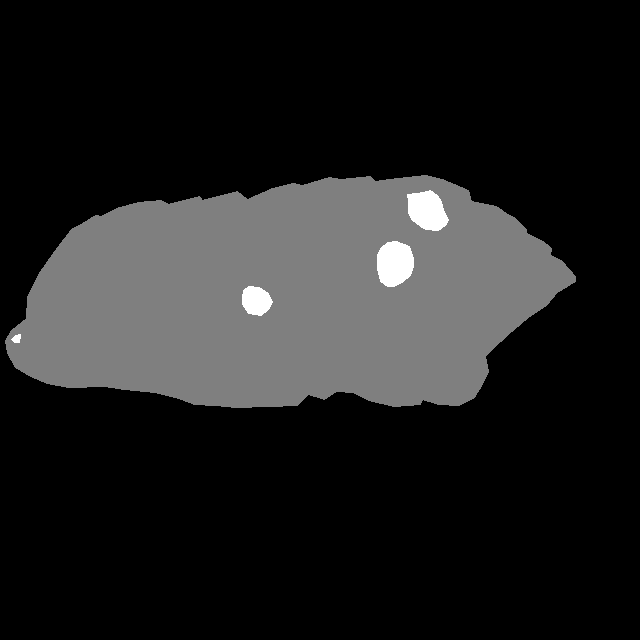

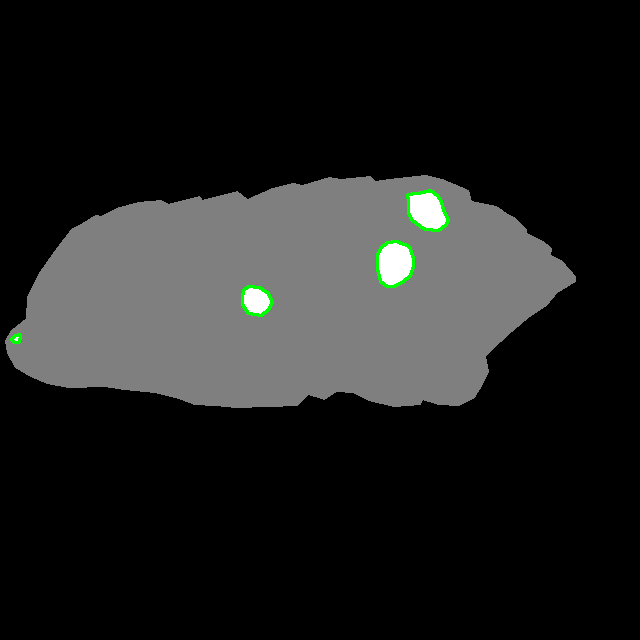

[(18, 334), (17, 335), (15, 335), (11, 339), (14, 342), (19, 342), (19, 339), (20, 338), (20, 334)]
[(248, 286), (246, 288), (245, 288), (243, 290), (243, 293), (242, 294), (242, 304), (243, 305), (243, 306), (245, 308), (245, 309), (247, 311), (247, 312), (248, 313), (251, 313), (252, 314), (257, 314), (258, 315), (261, 315), (264, 312), (265, 312), (269, 308), (269, 307), (270, 306), (270, 305), (271, 304), (271, 303), (272, 302), (272, 301), (271, 300), (271, 299), (270, 298), (270, 297), (269, 296), (269, 295), (268, 294), (268, 293), (267, 292), (266, 292), (264, 290), (263, 290), (261, 288), (260, 288), (259, 287), (254, 287), (253, 286)]
[(392, 241), (391, 242), (387, 242), (384, 245), (383, 245), (380, 248), (380, 249), (379, 250), (379, 251), (378, 252), (378, 253), (377, 254), (377, 270), (378, 271), (378, 274), (379, 275), (379, 278), (380, 279), (380, 281), (381, 282), (382, 282), (385, 285), (386, 285), (387, 286), (394, 286), (395, 285), (396, 285), (397, 284), (398, 284)

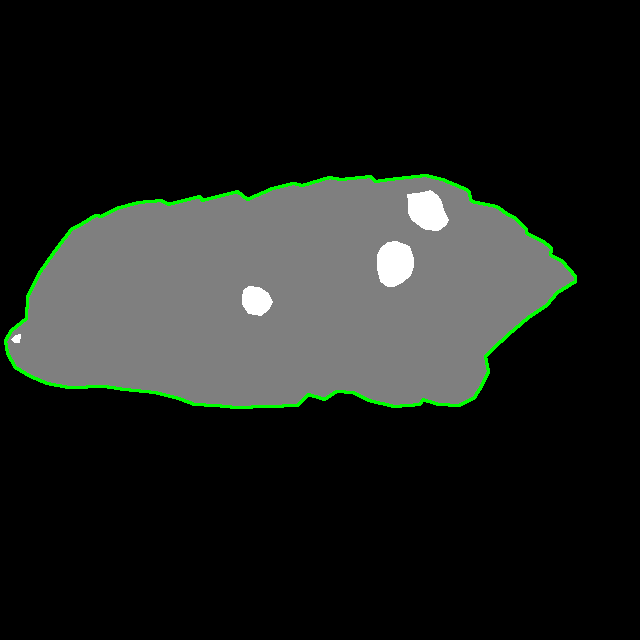

[(421, 175), (420, 176), (412, 176), (411, 177), (403, 177), (402, 178), (394, 178), (393, 179), (386, 179), (385, 180), (379, 180), (378, 181), (375, 181), (370, 176), (366, 176), (365, 177), (356, 177), (355, 178), (346, 178), (345, 179), (338, 179), (337, 178), (332, 178), (331, 177), (328, 177), (327, 178), (324, 178), (323, 179), (321, 179), (320, 180), (318, 180), (317, 181), (314, 181), (313, 182), (311, 182), (310, 183), (308, 183), (307, 184), (304, 184), (303, 185), (300, 185), (299, 184), (296, 184), (295, 183), (291, 183), (290, 184), (287, 184), (286, 185), (283, 185), (282, 186), (279, 186), (278, 187), (275, 187), (274, 188), (271, 188), (270, 189), (269, 189), (268, 190), (267, 190), (266, 191), (265, 191), (264, 192), (262, 192), (261, 193), (260, 193), (259, 194), (258, 194), (257, 195), (255, 195), (254, 196), (253, 196), (252, 197), (251, 197), (250, 198), (249, 198), (248, 199), (247, 199), (245, 197), (244, 197), (240, 193), (239, 193), (237, 191), (236, 191), (23

In [6]:
# Пример обработки контуров листа и болезни
image_test = cv2.imread('/content/Dataset/cedar_apple_rust/Apple_0003_label.png', cv2.IMREAD_GRAYSCALE)

# белые области
_, white_mask = cv2.threshold(image_test, 200, 255, cv2.THRESH_BINARY)
white_contours, _ = cv2.findContours(white_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
white_image_with_contours = cv2.cvtColor(image_test, cv2.COLOR_GRAY2BGR)
cv2.drawContours(white_image_with_contours, white_contours, -1, (0, 255, 0), 2)


# Серые области
gray_mask = cv2.inRange(image_test, 100, 200)
gray_contours, _ = cv2.findContours(gray_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
gray_image_with_contours = cv2.cvtColor(image_test, cv2.COLOR_GRAY2BGR)
cv2.drawContours(gray_image_with_contours, gray_contours, -1, (0, 255, 0), 2)

cv2_imshow(image_test)

white_contours = np_arr_to_list(white_contours)
cv2_imshow(white_image_with_contours)
for i in white_contours:
  print(i)

gray_contours = np_arr_to_list(gray_contours)
cv2_imshow(gray_image_with_contours)
for i in gray_contours:
  print(i)

In [104]:
def get_contours(image_test, dx, dy):
  image_test = cv2.cvtColor(image_test, cv2.COLOR_BGR2GRAY)

  # белые области
  _, white_mask = cv2.threshold(image_test, 200, 255, cv2.THRESH_BINARY)
  white_contours, _ = cv2.findContours(white_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # Серые области
  gray_mask = cv2.inRange(image_test, 100, 200)
  gray_contours, _ = cv2.findContours(gray_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  white_contours = np_arr_to_list(white_contours)
  gray_contours = np_arr_to_list(gray_contours)


  for i in range(len(white_contours)):
    for j in range(len(white_contours[i])):
      white_contours[i][j] = (white_contours[i][j][0] + dx, white_contours[i][j][1] + dy)

  for i in range(len(gray_contours)):
    for j in range(len(gray_contours[i])):
      gray_contours[i][j] = (gray_contours[i][j][0] + dx, gray_contours[i][j][1] + dy)

  return white_contours, gray_contours

In [19]:
image_masked_image_dict = defaultdict(dict)

# Заполнения словаря изображения-изображение маска
# Возможно для каждого датасета свой алгоритм

dataset1_folders = {
    "Apple": '/content/Dataset/cedar_apple_rust',
    "Soybean": "/content/Dataset/soybean_bacterial_blight",
    "Wheat": "/content/Dataset/wheat_stripe_rust"
}

dataset1_mask_postfix = '_label.png'

for plant_name in dataset1_folders.keys():
  for image_filepath in os.listdir(dataset1_folders[plant_name]):
    if '.jpg' in image_filepath:
      if plant_name in image_masked_image_dict:
        image_masked_image_dict[plant_name].append((
            image_filepath,
            image_filepath.split('.')[0] + dataset1_mask_postfix
        ))
      else:
        image_masked_image_dict[plant_name] = [(
            image_filepath,
            image_filepath.split('.')[0] + dataset1_mask_postfix
        )]

In [20]:
image_masked_image_dict

defaultdict(dict,
            {'Apple': [('Apple_0328.jpg', 'Apple_0328_label.png'),
              ('Apple_0371.jpg', 'Apple_0371_label.png'),
              ('Apple_0218.jpg', 'Apple_0218_label.png'),
              ('Apple_0159.jpg', 'Apple_0159_label.png'),
              ('Apple_0184.jpg', 'Apple_0184_label.png'),
              ('Apple_0369.jpg', 'Apple_0369_label.png'),
              ('Apple_0275.jpg', 'Apple_0275_label.png'),
              ('Apple_0269.jpg', 'Apple_0269_label.png'),
              ('Apple_0132.jpg', 'Apple_0132_label.png'),
              ('Apple_0289.jpg', 'Apple_0289_label.png'),
              ('Apple_0228.jpg', 'Apple_0228_label.png'),
              ('Apple_0015.jpg', 'Apple_0015_label.png'),
              ('Apple_0323.jpg', 'Apple_0323_label.png'),
              ('Apple_0223.jpg', 'Apple_0223_label.png'),
              ('Apple_0129.jpg', 'Apple_0129_label.png'),
              ('Apple_0117.jpg', 'Apple_0117_label.png'),
              ('Apple_0340.jpg', 'Apple_0340_

In [137]:
def generate_colallage(plant_count, image_number, mask_prefix, dir):
  random_images = []
  names = []
  deseases = []
  for _ in range(plant_count):
    rand_key = random.choice(list(image_masked_image_dict.keys()))
    random_images.append(
        [
            random.choice(image_masked_image_dict[rand_key]),
            dataset1_folders[rand_key]]
    )
    names.append(rand_key)
    deseases.append(dataset1_folders[rand_key].split('/')[-1].split('.')[0])

  output_path = f"sample{image_number}.jpg"
  output_mask_path = f"sample{image_number}{mask_prefix}.jpg"

  image_files = [f'{i[1]}/{i[0][0]}' for i in random_images]
  mask_files = [f'{i[1]}/{i[0][1]}' for i in random_images]

  images = []
  masks = []
  sizes_img = []
  sizes_mask = []

  for filepath_ind in range(len(image_files)):
      img = Image.open(image_files[filepath_ind]).convert("RGBA")
      mask = Image.open(mask_files[filepath_ind]).convert("RGBA")

      rand_w, rand_h = random.randint(250, 400), random.randint(250, 400)

      img = img.resize((rand_w, rand_h), Image.Resampling.LANCZOS)
      mask = mask.resize((rand_w, rand_h), Image.Resampling.LANCZOS)

      width, height = img.size
      width_m, height_m = mask.size

      sizes_img.append((width, height))
      sizes_mask.append((width_m, height_m))

      images.append(img)
      masks.append(mask)


  packer = newPacker(rotation=False)

  for idx, size in enumerate(sizes_img):
      packer.add_rect(*size, rid=idx)

  bin_width = 1500
  bin_height = 1500
  packer.add_bin(bin_width, bin_height)

  packer.pack()

  positions = []
  for rect in packer.rect_list():
      b, x, y, w, h, rid = rect
      positions.append((x, y, w, h, rid))


  canvas_width = bin_width
  canvas_height = bin_height
  canvas = Image.new('RGB', (canvas_width, canvas_height), (0, 0, 0))
  canvas_mask = Image.new('RGB', (canvas_width, canvas_height), (0, 0, 0))

  json_file = {}
  for x, y, w, h, rid in positions:
      img = images[rid]
      msk = masks[rid]

      msk_np = np.array(msk)
      white_contours, gray_contours = get_contours(msk_np, x, y)

      canvas.paste(img, (x, y), img.split()[3])
      canvas_mask.paste(msk, (x, y), msk.split()[3])

      json_file[rid] = {
          'plant_type': names[rid],
          'leaf_contour': gray_contours,
          'desease_contour': white_contours,
          'desease': deseases[rid]

      }

  canvas.save(dir + output_path)
  canvas_mask.save(dir + output_mask_path)

  json_path = os.path.join(dir, f"sample_{image_number}_annotation.json")
  with open(json_path, 'w') as f:
      json.dump(json_file, f)

In [139]:
plant_count = 20

dataset_imgs_to_generate = 100

generate_masks_postfix = '_mask'

if 'generated' in os.listdir('/content/'):
  for i in os.listdir('/content/generated'):
    os.remove(f'/content/generated/{i}')
else:
  os.mkdir('/content/generated/')

for i in range(dataset_imgs_to_generate):
  generate_colallage(plant_count, i, generate_masks_postfix, '/content/generated/')


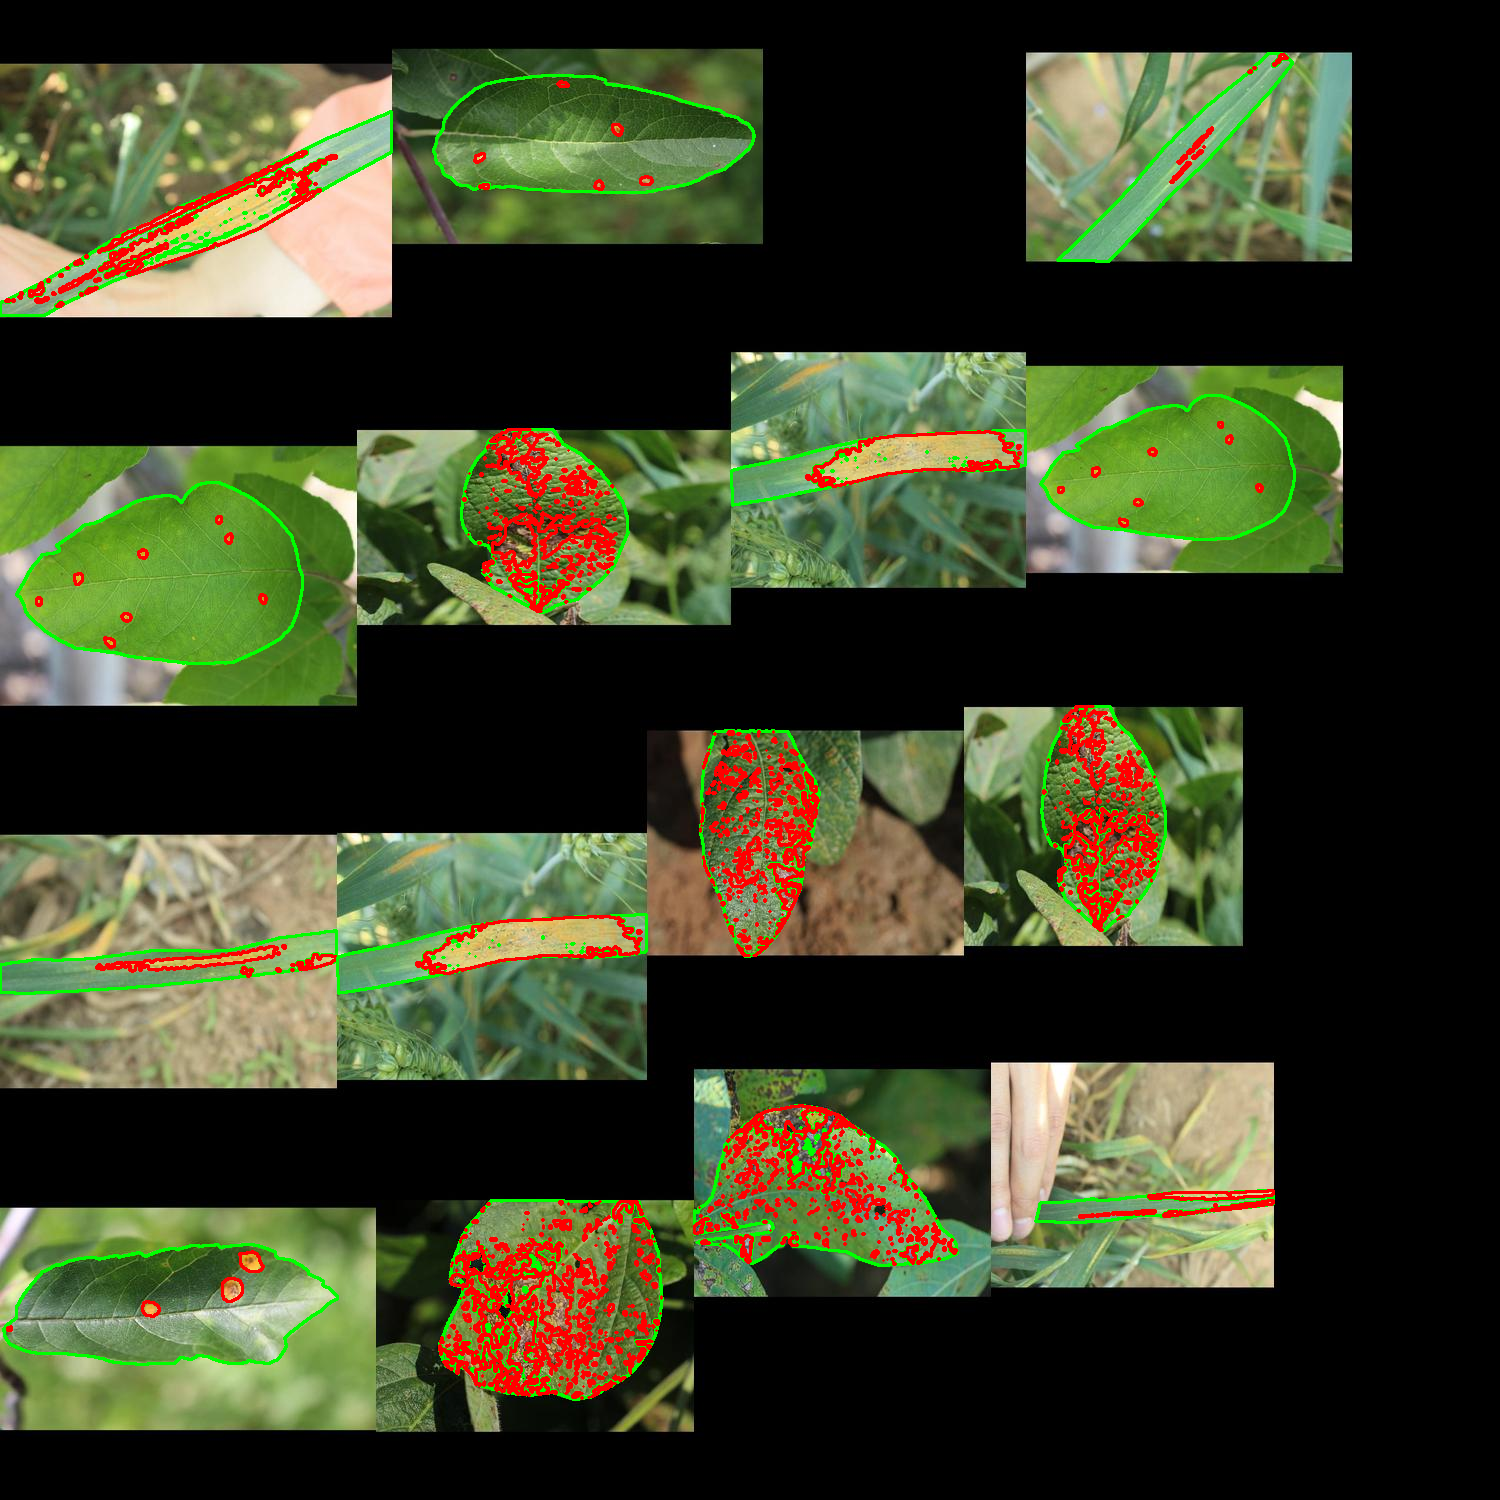

In [140]:
import json
import cv2
import numpy as np
import os

image_path = "/content/generated/sample0.jpg"
json_path = "/content/generated/sample_0_annotation.json"

with open(json_path, 'r') as f:
    data = json.load(f)

image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError("Не удалось загрузить изображение")

height, width = image.shape[:2]
blank_mask = np.zeros((height, width), dtype=np.uint8)

for key in data:
    obj = data[key]

    leaf_contours = obj.get("leaf_contour", [])
    disease_contours = obj.get("desease_contour", [])

    for contour in leaf_contours:
        pts = np.array(contour, dtype=np.int32)
        cv2.polylines(image, [pts], isClosed=True, color=(0, 255, 0), thickness=2)

    for contour in disease_contours:
        pts = np.array(contour, dtype=np.int32)
        cv2.polylines(image, [pts], isClosed=True, color=(0, 0, 255), thickness=2)

cv2_imshow(image)